In [1]:
# Imports

import numpy as np 

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV

Burada gerekli olan kütüphaneleri projemize ekledik.
NumPy kütüphanesini bilimsel hasaplamalar yapmak için kullandık.
Matplotlib kütüphanesini ekrana görsel çizdirirken kullandık.
Sklearn kütüphanesini makine öğrenmesi hesaplamaları için kullandık.

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.


Keras kütüphanesi yüksek seviyeli bir yapay sinir ağı kütüphanesidir. 
Yapay sinir ağımızı Keras yardımı ile oluşturduk.

In [3]:
# load the data
circle = np.load('C:/python36/data/circle.npy')
line = np.load('C:/python36/data/line.npy')
square = np.load('C:/python36/data/square.npy')
star = np.load('C:/python36/data/star.npy')
triangle = np.load('C:/python36/data/triangle.npy')

Burada yapay sinir ağımızın eğitimi ve testi için kullanacağımız verileri yükledik.
Format olarak NumPy kütüphanesinin sağladığı .npy formatını kullandık.
NumPy bu format için bir çok fonksiyon sağlamakta bu sebeple üzerinde işlem yapmak daha kolay olmaktadır.
Bu veriler Google'ın geliştirdiği Quick Draw isimli oyundan elde edilen veriler. Google bu verileri halkın kullanımına açık olarak paylaştı.
Projede kullanmak üzere beş adet seçeneği https://console.cloud.google.com/storage/quickdraw_dataset/full/numpy_bitmap adresinden indirdik ve belirli bir konuma kaydettik.
Deneme olarak daire, çizgi, dörtgen, yıldız ve üçgen çizimlerini kullandık.
Daha sonradan bu verilere eklemeler yaparak geliştirmeye devam edebiliriz.

In [4]:
# add a column with labels
circle = np.c_[circle, 0*np.ones(len(circle))]
line = np.c_[line, 1*np.ones(len(line))]
square = np.c_[square, 2*np.ones(len(square))]
star = np.c_[star, 3*np.ones(len(star))]
triangle = np.c_[triangle, 4*np.ones(len(triangle))]
# store the label codes in a dictionary
label_dict = {0:'circle', 1:'line', 2:'square', 3:'star', 4:'triangle'}

print(circle.shape)
print(line.shape)
print(square.shape)
print(star.shape)
print(triangle.shape)

(122876, 785)
(143549, 785)
(125145, 785)
(137619, 785)
(123170, 785)


Yüklediğimiz verilerin içerisinde yapay sinir ağının ihtiyaç duyduğu label'lar yani resimdeki çizimin ne olduğunu belirten kısım bulunmuyor. Bu sebeple verilere gerekli label'ları ekliyoruz.
Daha sonra bunları sözlüğümüze kaydediyor ve ekrana verilerimizin biçimlerini çizdiriyoruz.

In [5]:
def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''
    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

plot_samples fonksiyonu numpy dizisi formatında olan verilerimizi ekrana çizdirmek için kullanılıyor.

In [6]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Karmaşıklık matrisi',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 5)
        print("Normalizasyonlu Karmaşıklık Matrisi")
    else:
        print('Normalizasyonsuz Karmaşıklık Matrisi')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Doğru etiket')
    plt.xlabel('Öngörülen etiket')

plot_confusion_matrix foksiyonu karmaşıklık matrisini ekrana görsel bir şekilde çizdirmekte.

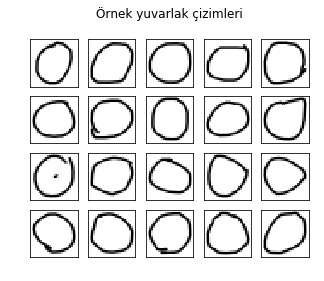

In [7]:
plot_samples(circle, title='Örnek yuvarlak çizimleri\n')

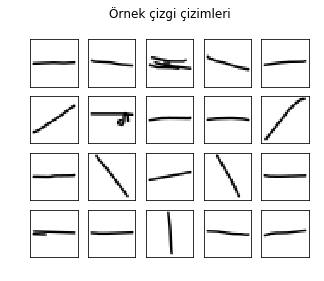

In [8]:
plot_samples(line, title='Örnek çizgi çizimleri\n')

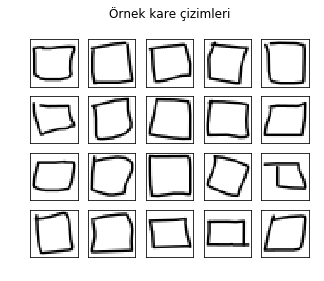

In [9]:
plot_samples(square, title='Örnek kare çizimleri\n')

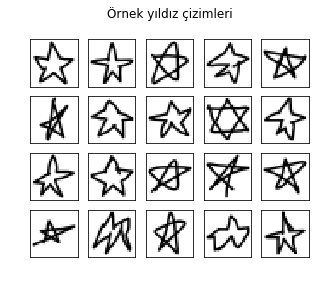

In [10]:
plot_samples(star, title='Örnek yıldız çizimleri\n')

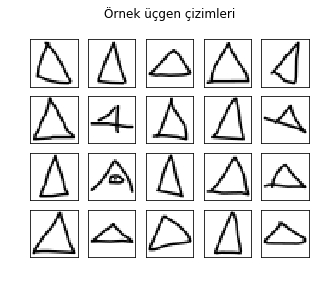

In [11]:
plot_samples(triangle, title='Örnek üçgen çizimleri\n')

In [12]:
X = np.concatenate((circle[:5000,:-1], line[:5000,:-1], square[:5000,:-1], star[:5000,:-1], triangle[:5000,:-1]), axis=0).astype('float32') # all columns but the last
y = np.concatenate((circle[:5000,-1], line[:5000,-1], square[:5000,-1], star[:5000,-1], triangle[:5000,-1]), axis=0).astype('float32') # the last column

X_train, X_test, y_train, y_test = train_test_split(X/255.,y,test_size=0.5,random_state=0)

Ayrı dizilerde bulunan verileri tek bir dizi olarak birleştirdik. 
X değişkenine sonuncusu hariç tüm sütunları atadık. Y değişkenine ise son sütunu atadık. 
Son satırda ise verileri eğitim ve test verisi olarak bölümlendirdik.

In [13]:
# one hot encode outputs
y_train_cnn = np_utils.to_categorical(y_train)
y_test_cnn = np_utils.to_categorical(y_test)
num_classes = y_test_cnn.shape[1]

Kera y label'larının one hot encodngden geçirilmesini gerektiriyor. Bu yüzden bu satırları ekledik.

In [14]:
# reshape to be [samples][pixels][width][height]
X_train_cnn = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

Verilerimizi 28x28 boyutunda olacak şekilde yeniden boyutlandırdık. Bu sinir ağına 784x1 vektörüne göre ek bilgi vermektedir.

In [ ]:
# define the CNN model
def cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(1, 28, 28), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Yapay sinir ağı modelimizi tanımladık. Yapay sinir ağımız aşağıdaki katmanlara sahip.
1. 5x5 boyutunda 30 adet özellik haritasına sahip evrimsel katman.
2. Havuz tabakası, maksimum 2x2 parçaya sahip.
3. 3x3 boyutunda 15 adet özellik haritasına sahip evrimsel katman.
4. Havuz tabakası, maksimum 2x2 parçaya sahip.
5. %20 olasılığa sahip bırakma katmanı.
6. Düzleştirme katmanı.
7. Tam bağlı katman, 128 nöron ve doğrultucu aktivasyona sahip.
8. Tam bağlı katman, 50 nöron ve doğrultucu aktivasyona sahip.
9. Çıktı katmanı.


In [ ]:
%%time

# build the model
model = cnn_model()
# Fit the model
model.fit(X_train_cnn, y_train_cnn, validation_data=(X_test_cnn, y_test_cnn), epochs=10, batch_size=200)
# Final evaluation of the model
scores = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print('Final CNN doğruluğu: ', scores[1])

Train on 12500 samples, validate on 12500 samples
Epoch 1/10
12500/12500 [==============================] - 57s 5ms/step - loss: 0.6548 - acc: 0.7378 - val_loss: 0.2685 - val_acc: 0.9353
Epoch 2/10
12500/12500 [==============================] - 65s 5ms/step - loss: 0.2128 - acc: 0.9406 - val_loss: 0.1812 - val_acc: 0.9503
Epoch 3/10
12500/12500 [==============================] - 56s 4ms/step - loss: 0.1533 - acc: 0.9570 - val_loss: 0.1573 - val_acc: 0.9558
Epoch 4/10
12500/12500 [==============================] - 63s 5ms/step - loss: 0.1344 - acc: 0.9616 - val_loss: 0.1643 - val_acc: 0.9563
Epoch 5/10
12500/12500 [==============================] - 53s 4ms/step - loss: 0.1277 - acc: 0.9621 - val_loss: 0.1534 - val_acc: 0.9574
Epoch 6/10
12400/12500 [============================>.] - ETA: 0s - loss: 0.1145 - acc: 0.9665

Burada modelimizi çalıştırdık ve doğruluk değerini ekrana yazdırdık.

In [ ]:
y_pred_cnn = model.predict_classes(X_test_cnn, batch_size=32, verbose=0)
acc_cnn = accuracy_score(y_test, y_pred_cnn)
print ('CNN doğruluğu: ',acc_cnn)

CNN doğruluğuna bakıyoruz.

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred_cnn)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['circle','line','square','star','triangle'],
                      title='Normalizasyonsuz Karmaşıklık Matrisi')

plt.show()

plot_confusion_matrix() metodumuzu kullanarak karmaşıklık matrisimizi çizdiriyoruz.

In [ ]:
cnn_probab = model.predict(X_test_cnn, batch_size=32, verbose=0)

# extract the probability for the label that was predicted:
p_max = np.amax(cnn_probab, axis=1)

plt.hist(p_max, normed=True, bins=list(np.linspace(0,1,11)));
plt.xlabel('Öngörülen sınıf p');

Model tarafından hangi olasılıkların tahmin edildiğine baktık.

In [ ]:
np.mean(p_max)

Bir tahmininin en yüksek kesinliğine baktık.

In [ ]:
np.amin(p_max)

Bir tahmininin en düşük kesinliğine baktık.

In [ ]:
fig, ax = plt.subplots(figsize=(6,15))

for i in list(range(10)):

    # plot probabilities:
    ax = plt.subplot2grid((10, 5), (i, 0), colspan=4);
    plt.bar(np.arange(5), cnn_probab[i], 0.35, align='center');
    plt.xticks(np.arange(5), ['circle','line','square','star','triangle'])
    plt.tick_params(axis='x', bottom='off', top='off')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.subplots_adjust(hspace = 0.5)

    # plot picture:
    ax = plt.subplot2grid((10, 5), (i, 4));
    plt.imshow(X_test[i].reshape((28,28)),cmap='gray_r', interpolation='nearest');
    plt.xlabel(label_dict[y_test[i]]); # get the label from the dict
    plt.xticks([])
    plt.yticks([])

Bazı tahminlere detaylı olarak baktık.

In [ ]:
fig, ax = plt.subplots(figsize=(6,15))

for i in list(range(10)):
    
    # plot probabilities:
    ax = plt.subplot2grid((10, 5), (i, 0), colspan=4);
    plt.bar(np.arange(5), cnn_probab[p_max<0.4][i], 0.35, align='center');
    plt.xticks(np.arange(5), ['circle','line','square','star','triangle'])
    plt.tick_params(axis='x', bottom='off', top='off')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.subplots_adjust(hspace = 0.5)

    # plot picture:
    ax = plt.subplot2grid((10, 5), (i, 4));
    plt.imshow(X_test[p_max<0.4][i].reshape((28,28)),cmap='gray_r', interpolation='nearest');
    plt.xlabel(label_dict[y_test[p_max<0.4][i]]); # get the label from the dict
    plt.xticks([])
    plt.yticks([])

In [ ]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

Modelimizin ağırlıklarını kaydettik. Bu ağırlıkları tahmin yapacağımız zaman kullanacağız.